In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Bidirectional, TimeDistributed, Flatten, Activation, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint

from tqdm.notebook import tqdm
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

# Load & Prepare Data

In [2]:
# Load Data
df = yf.download(tickers='RCDO.L', start='2012-01-01', end='2023-01-01')
df = df[['Close']]
df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


In [3]:
# training between 2012 and 2022
train_data_df = df[df.index < '2022-01-01'].copy()

# validation on 2022
val_data_df = df[df.index >= '2022-01-01'].copy()

display(train_data_df, val_data_df)

,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2021-12-23,465.0
2021-12-24,464.0
2021-12-29,462.0


,Close
Date,
2022-01-04,457.0
2022-01-05,463.0
2022-01-06,466.0
2022-01-07,467.0
2022-01-10,463.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


In [4]:
q_90 = int(len(train_data_df) * .9)
train_data_df[q_90:]

,Close
Date,
2021-01-04,339.0
2021-01-05,342.0
2021-01-06,340.0
2021-01-07,348.0
2021-01-08,339.0
...,...
2021-12-23,465.0
2021-12-24,464.0
2021-12-29,462.0


# Models

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.yticks([i/1000 for i in range(0, 25, 5)])
    plt.legend()
    plt.show()

In [6]:
def visualise_predicitons(test_data_df, pred):
    """Plot predictions against actual test data"""
    
    pred_ = pd.DataFrame(test_data_df['Close'])
    pred_['predicted close'] = pred
    
    plt.figure(figsize=(28,12))
    sns.lineplot(test_data_df['Close'])
    sns.lineplot(pred_['predicted close'])
    plt.show()

In [7]:
def run_model(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    ##### Run model #####
    model = chosen_model
    model.summary()
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)
    
    ##### Plot loss #####
    plot_loss(history)

    ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
    print("Generate predictions for 7 samples")
    predictions = model.predict(x_val[:7])
    print("predictions shape:", predictions.shape)
    print(predictions)
    
    ##### Metrics #####
    pred = model.predict(x_val)
    print(pred.shape)

    # Inverse MinMax Transformation
    # Requires same amount of fields
    # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
    # create empty table with 12 fields
    pred_like = np.zeros(shape=(len(pred), 1) )
    # put the predicted values in the right field
    pred_like[:,0] = pred[:,0]
    # inverse transform and then select the right field
    pred = scaler.inverse_transform(pred_like)[:,0]

    print('mae:', mean_absolute_error(val_data_df['Close'], pred))
    print('mape:', mean_absolute_percentage_error(val_data_df['Close'], pred))
    print('mse:', mean_squared_error(val_data_df['Close'], pred))
    print('rmse:', math.sqrt(mean_squared_error(val_data_df['Close'], pred)))

    ##### Visualise #####
    print(y_val.shape, pred.shape)
    visualise_predicitons(val_data_df, pred)

    display(pd.DataFrame(data={'Train Predictions':pred.flatten(), 'Actuals':val_data_df['Close']}))

In [8]:
def run_model_average(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    mape_values = []
    mae_values = []
    mse_values = []
    rmse_values = []
    
    for i in (range(35)):
        
        ##### Run model #####
        model = chosen_model
        model.summary()
        model.compile(optimizer='adam', 
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])

        history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)

        ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
        print("Generate predictions for 7 samples")
        predictions = model.predict(x_val[:7])
        print("predictions shape:", predictions.shape)
        print(predictions)

        ##### Metrics #####
        pred = model.predict(x_val)
        print(pred.shape)

        # Inverse MinMax Transformation
        # Requires same amount of fields
        # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
        # create empty table with 12 fields
        pred_like = np.zeros(shape=(len(pred), 1) )
        # put the predicted values in the right field
        pred_like[:,0] = pred[:,0]
        # inverse transform and then select the right field
        pred = scaler.inverse_transform(pred_like)[:,0]
    
        mae_values.append(mean_absolute_error(val_data_df['Close'], pred))
        mape_values.append(mean_absolute_percentage_error(val_data_df['Close'], pred))
        mse_values.append(mean_squared_error(val_data_df['Close'], pred))
        rmse_values.append(math.sqrt(mean_squared_error(val_data_df['Close'], pred)))
        
        print(mean(mae_values), mean(mape_values), mean(mse_values), mean(rmse_values))
        
    return mae_values, mape_values, mse_values, rmse_values

In [9]:
compare_df = pd.DataFrame(columns=['Name', 'MAE', 'MAPE', 'MSE', 'RMSE'])

## Vanilla LSTM

In [10]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# # vanilla LSTM
# def create_model(num_units):
#     model = Sequential()
#     model.add(LSTM(num_units, input_shape=(7,1)))
#     model.add(Dense(1, activation='tanh'))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])
#     return model

# # Create a KerasClassifier object
# model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# # Define the hyperparameter grid
# param_grid = {'num_units': [140, 120, 100, 70]}

# # Create a GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# # Fit the GridSearchCV object to the data
# grid_result = grid.fit(x_train, y_train)

# # Print the best parameters
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

## Output: 'Best: 0.001764 using {'num_units': 140}'

In [11]:
def vanilla_LSTM():
    model = Sequential()    
    model.add(LSTM(units=140, input_shape=(7, 1)))
    model.add(Dense(1, activation='tanh'))
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 140)               79520     
                                                                 
 dense (Dense)               (None, 1)                 141       
                                                                 
Total params: 79,661
Trainable params: 79,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 2s 10ms/step - loss: 0.0230 - mean_absolute_error: 0.0921 - val_loss: 5.6773e-04 - val_mean_absolute_error: 0.0185
Epoch 2/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - val_loss: 4.8255e-04 - val_mean_absolute_error: 0.0169
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_absolute_error: 0.0261 - v

Epoch 45/100
71/71 [==============================] - 0s 5ms/step - loss: 5.3559e-04 - mean_absolute_error: 0.0156 - val_loss: 2.0603e-04 - val_mean_absolute_error: 0.0105
Epoch 46/100
71/71 [==============================] - 0s 6ms/step - loss: 5.4001e-04 - mean_absolute_error: 0.0158 - val_loss: 1.7662e-04 - val_mean_absolute_error: 0.0096
Epoch 47/100
71/71 [==============================] - 0s 5ms/step - loss: 5.7465e-04 - mean_absolute_error: 0.0166 - val_loss: 2.1349e-04 - val_mean_absolute_error: 0.0113
Epoch 48/100
71/71 [==============================] - 0s 5ms/step - loss: 5.1916e-04 - mean_absolute_error: 0.0152 - val_loss: 1.9661e-04 - val_mean_absolute_error: 0.0101
Epoch 49/100
71/71 [==============================] - 0s 5ms/step - loss: 5.3743e-04 - mean_absolute_error: 0.0158 - val_loss: 1.7180e-04 - val_mean_absolute_error: 0.0094
Epoch 50/100
71/71 [==============================] - 0s 5ms/step - loss: 5.2260e-04 - mean_absolute_error: 0.0156 - val_loss: 1.7193e-04 - 

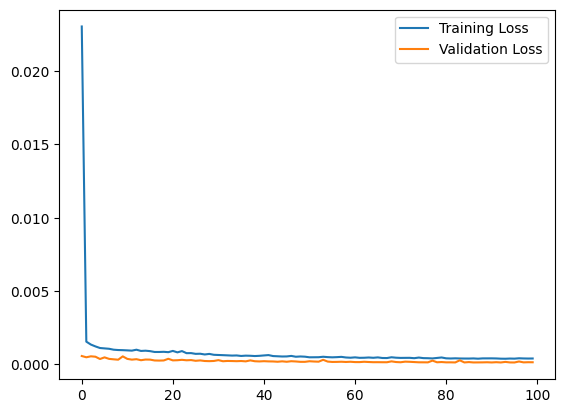

Generate predictions for 7 samples
1/1 [==============================] - 0s 342ms/step
predictions shape: (7, 1)
[[0.18245694]
 [0.19147703]
 [0.20096569]
 [0.20519386]
 [0.20614442]
 [0.20127927]
 [0.19680579]]
8/8 [==============================] - 0s 2ms/step
(250, 1)
mae: 6.212832045629621
mape: 0.014739822241842549
mse: 69.81565336924467
rmse: 8.355576184156583
(250,) (250,)


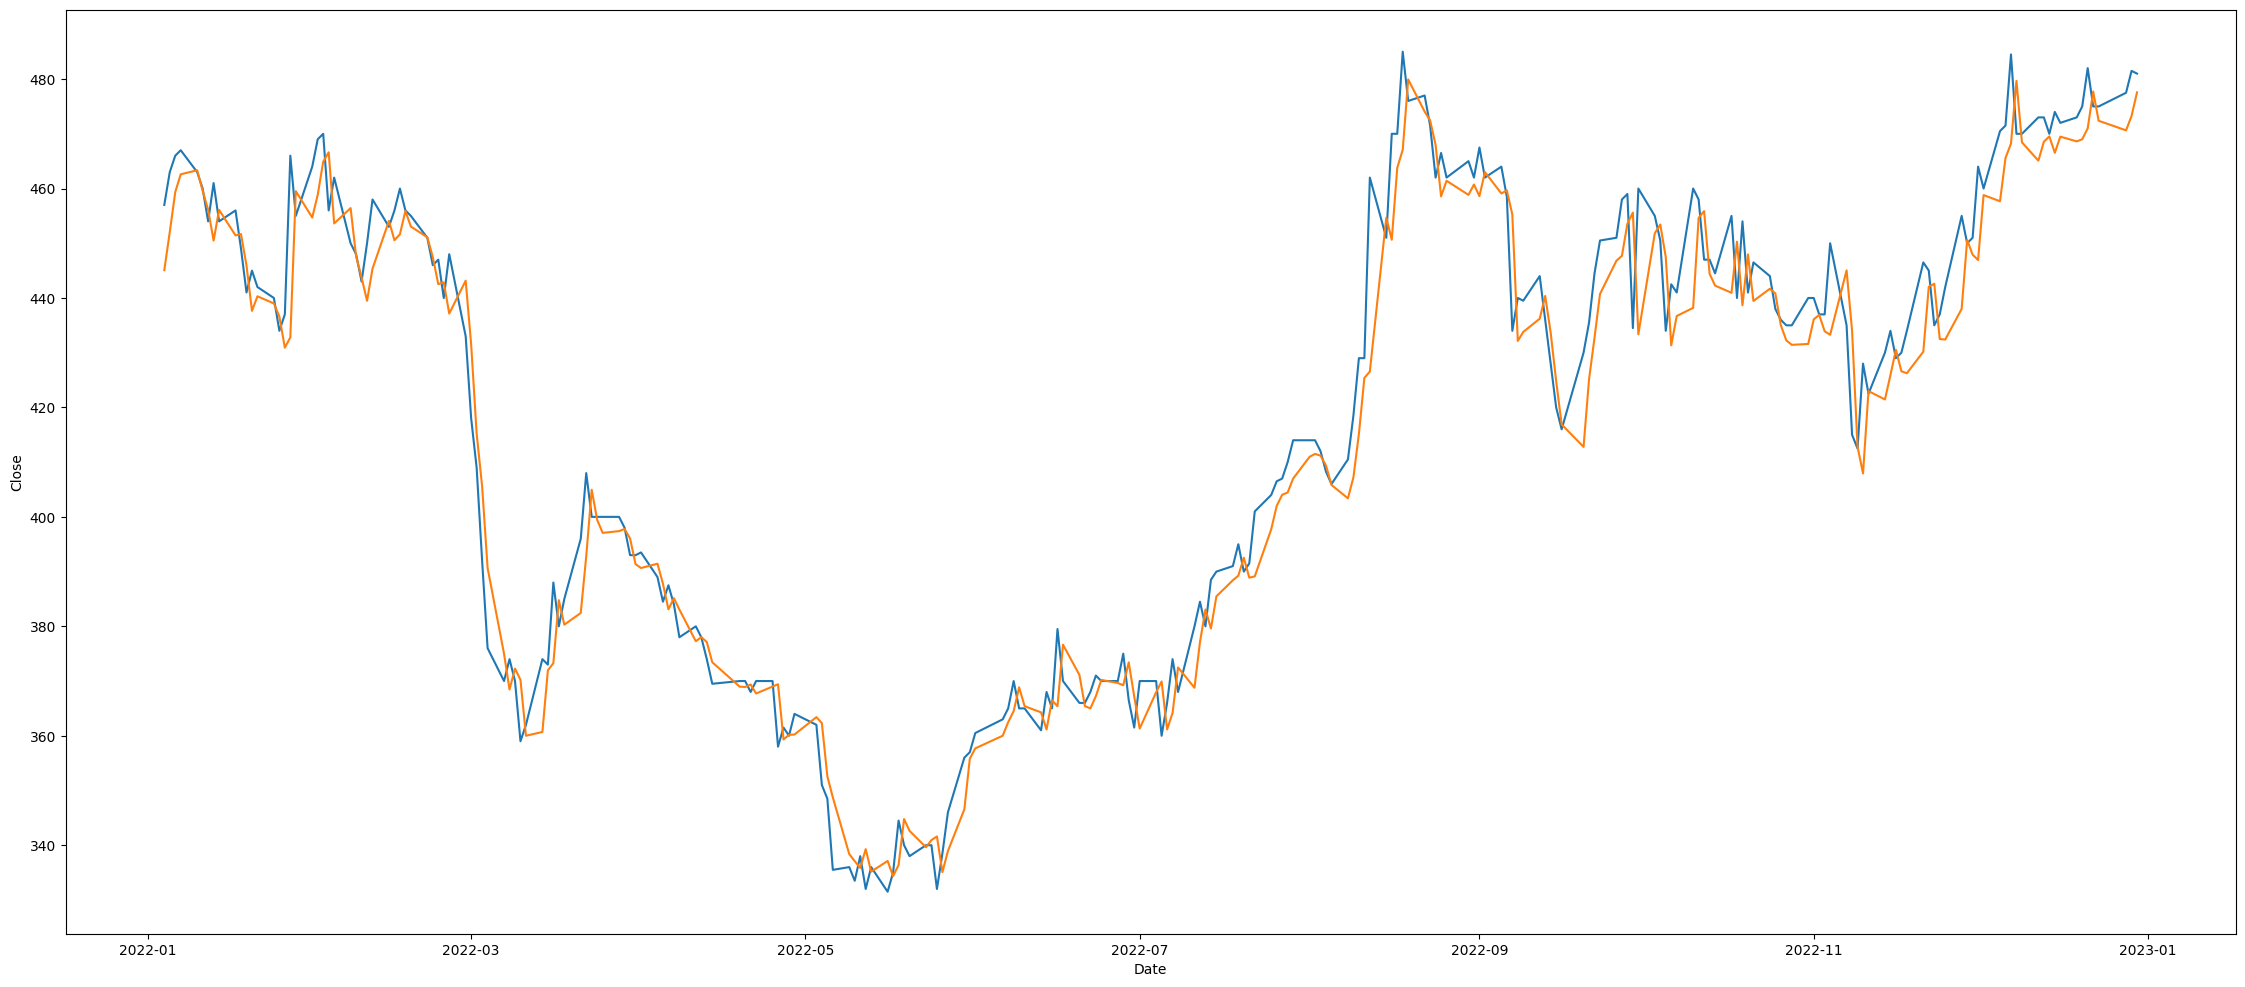

,Train Predictions,Actuals
Date,,
2022-01-04,445.083073,457.0
2022-01-05,452.033052,463.0
2022-01-06,459.344062,466.0
2022-01-07,462.601871,467.0
2022-01-10,463.334277,463.0
...,...,...
2022-12-22,477.720529,475.0
2022-12-23,472.378730,475.0
2022-12-28,470.631441,477.5


In [12]:
run_model(train_data_df, val_data_df, chosen_model = vanilla_LSTM())

In [13]:
mae_values, mape_values, mse_values, rmse_values = run_model_average(train_data_df, val_data_df, chosen_model = vanilla_LSTM())
 
model_dict = {
'Name':'Vanilla LSTM 2',
'MAE': round(mean(mae_values), 4),
"MAPE": round(mean(mape_values), 4),
"MSE": round(mean(mse_values), 4),
"RMSE": round(mean(rmse_values), 4)
}

compare_df = compare_df.append(model_dict, ignore_index=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 140)               79520     
                                                                 
 dense_1 (Dense)             (None, 1)                 141       
                                                                 
Total params: 79,661
Trainable params: 79,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 2s 10ms/step - loss: 0.0183 - mean_absolute_error: 0.0812 - val_loss: 5.0333e-04 - val_mean_absolute_error: 0.0173
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - val_loss: 4.7125e-04 - val_mean_absolute_error: 0.0167
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_absolute_error: 0.0261 -

Epoch 45/100
71/71 [==============================] - 0s 6ms/step - loss: 5.4243e-04 - mean_absolute_error: 0.0161 - val_loss: 2.1328e-04 - val_mean_absolute_error: 0.0109
Epoch 46/100
71/71 [==============================] - 0s 6ms/step - loss: 5.3519e-04 - mean_absolute_error: 0.0157 - val_loss: 1.7850e-04 - val_mean_absolute_error: 0.0096
Epoch 47/100
71/71 [==============================] - 0s 6ms/step - loss: 5.3605e-04 - mean_absolute_error: 0.0160 - val_loss: 1.6937e-04 - val_mean_absolute_error: 0.0093
Epoch 48/100
71/71 [==============================] - 0s 6ms/step - loss: 5.0154e-04 - mean_absolute_error: 0.0153 - val_loss: 1.9482e-04 - val_mean_absolute_error: 0.0103
Epoch 49/100
71/71 [==============================] - 0s 6ms/step - loss: 4.8954e-04 - mean_absolute_error: 0.0150 - val_loss: 1.6652e-04 - val_mean_absolute_error: 0.0091
Epoch 50/100
71/71 [==============================] - 0s 6ms/step - loss: 4.7984e-04 - mean_absolute_error: 0.0148 - val_loss: 1.5674e-04 - 

Epoch 34/100
71/71 [==============================] - 0s 5ms/step - loss: 3.9300e-04 - mean_absolute_error: 0.0137 - val_loss: 1.2476e-04 - val_mean_absolute_error: 0.0079
Epoch 35/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7247e-04 - mean_absolute_error: 0.0132 - val_loss: 1.4085e-04 - val_mean_absolute_error: 0.0087
Epoch 36/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7667e-04 - mean_absolute_error: 0.0133 - val_loss: 1.3443e-04 - val_mean_absolute_error: 0.0084
Epoch 37/100
71/71 [==============================] - 0s 6ms/step - loss: 3.7177e-04 - mean_absolute_error: 0.0132 - val_loss: 1.3564e-04 - val_mean_absolute_error: 0.0082
Epoch 38/100
71/71 [==============================] - 0s 6ms/step - loss: 3.6886e-04 - mean_absolute_error: 0.0133 - val_loss: 1.6063e-04 - val_mean_absolute_error: 0.0093
Epoch 39/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7224e-04 - mean_absolute_error: 0.0132 - val_loss: 1.9526e-04 - 

Epoch 23/100
71/71 [==============================] - 0s 5ms/step - loss: 3.8465e-04 - mean_absolute_error: 0.0135 - val_loss: 1.5982e-04 - val_mean_absolute_error: 0.0093
Epoch 24/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7517e-04 - mean_absolute_error: 0.0135 - val_loss: 1.5157e-04 - val_mean_absolute_error: 0.0089
Epoch 25/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7157e-04 - mean_absolute_error: 0.0132 - val_loss: 1.3592e-04 - val_mean_absolute_error: 0.0082
Epoch 26/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7122e-04 - mean_absolute_error: 0.0132 - val_loss: 1.4641e-04 - val_mean_absolute_error: 0.0087
Epoch 27/100
71/71 [==============================] - 0s 5ms/step - loss: 3.6170e-04 - mean_absolute_error: 0.0131 - val_loss: 1.5227e-04 - val_mean_absolute_error: 0.0093
Epoch 28/100
71/71 [==============================] - 0s 5ms/step - loss: 3.6332e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3876e-04 - 

Epoch 12/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5942e-04 - mean_absolute_error: 0.0130 - val_loss: 1.4469e-04 - val_mean_absolute_error: 0.0089
Epoch 13/100
71/71 [==============================] - 0s 6ms/step - loss: 3.6260e-04 - mean_absolute_error: 0.0130 - val_loss: 1.6752e-04 - val_mean_absolute_error: 0.0096
Epoch 14/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5914e-04 - mean_absolute_error: 0.0131 - val_loss: 1.4000e-04 - val_mean_absolute_error: 0.0084
Epoch 15/100
71/71 [==============================] - 0s 6ms/step - loss: 3.6270e-04 - mean_absolute_error: 0.0131 - val_loss: 1.2796e-04 - val_mean_absolute_error: 0.0079
Epoch 16/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5200e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4260e-04 - val_mean_absolute_error: 0.0085
Epoch 17/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5413e-04 - mean_absolute_error: 0.0127 - val_loss: 1.2728e-04 - 

Epoch 1/100
71/71 [==============================] - 2s 10ms/step - loss: 3.6256e-04 - mean_absolute_error: 0.0131 - val_loss: 1.3518e-04 - val_mean_absolute_error: 0.0084
Epoch 2/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5905e-04 - mean_absolute_error: 0.0129 - val_loss: 1.8706e-04 - val_mean_absolute_error: 0.0104
Epoch 3/100
71/71 [==============================] - 0s 6ms/step - loss: 3.4805e-04 - mean_absolute_error: 0.0127 - val_loss: 1.6955e-04 - val_mean_absolute_error: 0.0097
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4967e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4195e-04 - val_mean_absolute_error: 0.0085
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5332e-04 - mean_absolute_error: 0.0128 - val_loss: 1.7156e-04 - val_mean_absolute_error: 0.0098
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5191e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3250e-04 - val_m

Epoch 49/100
71/71 [==============================] - 0s 6ms/step - loss: 3.4793e-04 - mean_absolute_error: 0.0127 - val_loss: 1.2574e-04 - val_mean_absolute_error: 0.0079
Epoch 50/100
71/71 [==============================] - 0s 6ms/step - loss: 3.4997e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3850e-04 - val_mean_absolute_error: 0.0086
Epoch 51/100
71/71 [==============================] - 0s 6ms/step - loss: 3.4354e-04 - mean_absolute_error: 0.0126 - val_loss: 1.2750e-04 - val_mean_absolute_error: 0.0079
Epoch 52/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5142e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3209e-04 - val_mean_absolute_error: 0.0082
Epoch 53/100
71/71 [==============================] - 0s 6ms/step - loss: 3.4556e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3774e-04 - val_mean_absolute_error: 0.0082
Epoch 54/100
71/71 [==============================] - 0s 6ms/step - loss: 3.4370e-04 - mean_absolute_error: 0.0126 - val_loss: 1.2890e-04 - 

Epoch 38/100
71/71 [==============================] - 0s 6ms/step - loss: 3.4249e-04 - mean_absolute_error: 0.0129 - val_loss: 1.4166e-04 - val_mean_absolute_error: 0.0083
Epoch 39/100
71/71 [==============================] - 0s 6ms/step - loss: 3.3890e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3659e-04 - val_mean_absolute_error: 0.0083
Epoch 40/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4215e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3442e-04 - val_mean_absolute_error: 0.0084
Epoch 41/100
71/71 [==============================] - 0s 5ms/step - loss: 3.3875e-04 - mean_absolute_error: 0.0127 - val_loss: 1.2840e-04 - val_mean_absolute_error: 0.0081
Epoch 42/100
71/71 [==============================] - 0s 6ms/step - loss: 3.3991e-04 - mean_absolute_error: 0.0127 - val_loss: 1.6497e-04 - val_mean_absolute_error: 0.0094
Epoch 43/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4366e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3087e-04 - 

Epoch 27/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2606e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3889e-04 - val_mean_absolute_error: 0.0084
Epoch 28/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2981e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4096e-04 - val_mean_absolute_error: 0.0083
Epoch 29/100
71/71 [==============================] - 0s 6ms/step - loss: 3.2228e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3864e-04 - val_mean_absolute_error: 0.0083
Epoch 30/100
71/71 [==============================] - 1s 9ms/step - loss: 3.2015e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4695e-04 - val_mean_absolute_error: 0.0089
Epoch 31/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2602e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3290e-04 - val_mean_absolute_error: 0.0080
Epoch 32/100
71/71 [==============================] - 0s 6ms/step - loss: 3.3014e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4597e-04 - 

Epoch 16/100
71/71 [==============================] - 0s 6ms/step - loss: 3.1897e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3584e-04 - val_mean_absolute_error: 0.0081
Epoch 17/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1974e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4314e-04 - val_mean_absolute_error: 0.0087
Epoch 18/100
71/71 [==============================] - 0s 6ms/step - loss: 3.2191e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4502e-04 - val_mean_absolute_error: 0.0088
Epoch 19/100
71/71 [==============================] - 0s 6ms/step - loss: 3.1616e-04 - mean_absolute_error: 0.0123 - val_loss: 1.5452e-04 - val_mean_absolute_error: 0.0091
Epoch 20/100
71/71 [==============================] - 0s 6ms/step - loss: 3.2199e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4623e-04 - val_mean_absolute_error: 0.0089
Epoch 21/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1986e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3980e-04 - 

Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 3.1269e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3703e-04 - val_mean_absolute_error: 0.0084
Epoch 6/100
71/71 [==============================] - 0s 6ms/step - loss: 3.2086e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3223e-04 - val_mean_absolute_error: 0.0081
Epoch 7/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1396e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4576e-04 - val_mean_absolute_error: 0.0084
Epoch 8/100
71/71 [==============================] - 0s 6ms/step - loss: 3.1075e-04 - mean_absolute_error: 0.0123 - val_loss: 1.6573e-04 - val_mean_absolute_error: 0.0097
Epoch 9/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2135e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3603e-04 - val_mean_absolute_error: 0.0081
Epoch 10/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1878e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3823e-04 - val_m

Epoch 53/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1681e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3197e-04 - val_mean_absolute_error: 0.0080
Epoch 54/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1763e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4906e-04 - val_mean_absolute_error: 0.0088
Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2083e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3132e-04 - val_mean_absolute_error: 0.0082
Epoch 56/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1233e-04 - mean_absolute_error: 0.0123 - val_loss: 1.2923e-04 - val_mean_absolute_error: 0.0079
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1625e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4266e-04 - val_mean_absolute_error: 0.0084
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2527e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4167e-04 - 

Epoch 42/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0800e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3192e-04 - val_mean_absolute_error: 0.0082
Epoch 43/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1849e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4508e-04 - val_mean_absolute_error: 0.0087
Epoch 44/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1703e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3105e-04 - val_mean_absolute_error: 0.0081
Epoch 45/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1514e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3450e-04 - val_mean_absolute_error: 0.0081
Epoch 46/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1177e-04 - mean_absolute_error: 0.0123 - val_loss: 1.5047e-04 - val_mean_absolute_error: 0.0091
Epoch 47/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1749e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3110e-04 - 

Epoch 31/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1929e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3373e-04 - val_mean_absolute_error: 0.0081
Epoch 32/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0884e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3888e-04 - val_mean_absolute_error: 0.0083
Epoch 33/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1449e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3323e-04 - val_mean_absolute_error: 0.0080
Epoch 34/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0598e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3466e-04 - val_mean_absolute_error: 0.0082
Epoch 35/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2267e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3540e-04 - val_mean_absolute_error: 0.0082
Epoch 36/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0836e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3835e-04 - 

Epoch 20/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0912e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4044e-04 - val_mean_absolute_error: 0.0086
Epoch 21/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0876e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3379e-04 - val_mean_absolute_error: 0.0081
Epoch 22/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0585e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3555e-04 - val_mean_absolute_error: 0.0082
Epoch 23/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0980e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4255e-04 - val_mean_absolute_error: 0.0086
Epoch 24/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0616e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4165e-04 - val_mean_absolute_error: 0.0087
Epoch 25/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0852e-04 - mean_absolute_error: 0.0124 - val_loss: 1.5080e-04 - 

Epoch 9/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0026e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4356e-04 - val_mean_absolute_error: 0.0084
Epoch 10/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0085e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4767e-04 - val_mean_absolute_error: 0.0086
Epoch 11/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0562e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4964e-04 - val_mean_absolute_error: 0.0087
Epoch 12/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0324e-04 - mean_absolute_error: 0.0122 - val_loss: 1.5099e-04 - val_mean_absolute_error: 0.0090
Epoch 13/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0458e-04 - mean_absolute_error: 0.0121 - val_loss: 1.6269e-04 - val_mean_absolute_error: 0.0093
Epoch 14/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0272e-04 - mean_absolute_error: 0.0122 - val_loss: 1.9106e-04 - v

 lstm_1 (LSTM)               (None, 140)               79520     
                                                                 
 dense_1 (Dense)             (None, 1)                 141       
                                                                 
Total params: 79,661
Trainable params: 79,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 2s 11ms/step - loss: 2.9933e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5789e-04 - val_mean_absolute_error: 0.0092
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9963e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4666e-04 - val_mean_absolute_error: 0.0087
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0700e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4337e-04 - val_mean_absolute_error: 0.0085
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0141e-04 - 

Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0445e-04 - mean_absolute_error: 0.0124 - val_loss: 1.6250e-04 - val_mean_absolute_error: 0.0092
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9797e-04 - mean_absolute_error: 0.0122 - val_loss: 1.5347e-04 - val_mean_absolute_error: 0.0090
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0471e-04 - mean_absolute_error: 0.0122 - val_loss: 1.6270e-04 - val_mean_absolute_error: 0.0093
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0059e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4506e-04 - val_mean_absolute_error: 0.0085
Epoch 97/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0089e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5200e-04 - val_mean_absolute_error: 0.0089
Epoch 98/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9887e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4906e-04 - 

Epoch 35/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9889e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4617e-04 - val_mean_absolute_error: 0.0085
Epoch 36/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9870e-04 - mean_absolute_error: 0.0120 - val_loss: 1.7125e-04 - val_mean_absolute_error: 0.0096
Epoch 37/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0239e-04 - mean_absolute_error: 0.0122 - val_loss: 1.5667e-04 - val_mean_absolute_error: 0.0089
Epoch 38/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9769e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5236e-04 - val_mean_absolute_error: 0.0088
Epoch 39/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9497e-04 - mean_absolute_error: 0.0121 - val_loss: 1.7529e-04 - val_mean_absolute_error: 0.0098
Epoch 40/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9412e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5418e-04 - 

Epoch 24/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0154e-04 - mean_absolute_error: 0.0122 - val_loss: 1.6731e-04 - val_mean_absolute_error: 0.0093
Epoch 25/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9771e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5969e-04 - val_mean_absolute_error: 0.0093
Epoch 26/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9697e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5692e-04 - val_mean_absolute_error: 0.0090
Epoch 27/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9104e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5700e-04 - val_mean_absolute_error: 0.0089
Epoch 28/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9937e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5467e-04 - val_mean_absolute_error: 0.0090
Epoch 29/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9679e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5742e-04 - 

Epoch 13/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9143e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6138e-04 - val_mean_absolute_error: 0.0091
Epoch 14/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9360e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6216e-04 - val_mean_absolute_error: 0.0092
Epoch 15/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9265e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6222e-04 - val_mean_absolute_error: 0.0091
Epoch 16/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0608e-04 - mean_absolute_error: 0.0123 - val_loss: 1.5412e-04 - val_mean_absolute_error: 0.0088
Epoch 17/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0550e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5845e-04 - val_mean_absolute_error: 0.0089
Epoch 18/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0357e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5067e-04 - 

Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9115e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6224e-04 - val_mean_absolute_error: 0.0091
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9334e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5726e-04 - val_mean_absolute_error: 0.0089
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8850e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5972e-04 - val_mean_absolute_error: 0.0089
Epoch 5/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9313e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6270e-04 - val_mean_absolute_error: 0.0091
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9408e-04 - mean_absolute_error: 0.0119 - val_loss: 1.8127e-04 - val_mean_absolute_error: 0.0099
Epoch 7/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9407e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5368e-04 - val_me

Epoch 50/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9125e-04 - mean_absolute_error: 0.0119 - val_loss: 1.8305e-04 - val_mean_absolute_error: 0.0100
Epoch 51/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9490e-04 - mean_absolute_error: 0.0121 - val_loss: 1.7252e-04 - val_mean_absolute_error: 0.0094
Epoch 52/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8728e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7667e-04 - val_mean_absolute_error: 0.0096
Epoch 53/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9210e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5322e-04 - val_mean_absolute_error: 0.0087
Epoch 54/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8719e-04 - mean_absolute_error: 0.0118 - val_loss: 1.6468e-04 - val_mean_absolute_error: 0.0092
Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8679e-04 - mean_absolute_error: 0.0118 - val_loss: 1.8760e-04 - 

Epoch 39/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9169e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5747e-04 - val_mean_absolute_error: 0.0089
Epoch 40/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8988e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5370e-04 - val_mean_absolute_error: 0.0089
Epoch 41/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8713e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7393e-04 - val_mean_absolute_error: 0.0096
Epoch 42/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8496e-04 - mean_absolute_error: 0.0118 - val_loss: 1.8506e-04 - val_mean_absolute_error: 0.0099
Epoch 43/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9097e-04 - mean_absolute_error: 0.0119 - val_loss: 1.9932e-04 - val_mean_absolute_error: 0.0104
Epoch 44/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8929e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6358e-04 - 

Epoch 28/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9557e-04 - mean_absolute_error: 0.0120 - val_loss: 2.0827e-04 - val_mean_absolute_error: 0.0113
Epoch 29/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9453e-04 - mean_absolute_error: 0.0120 - val_loss: 1.7273e-04 - val_mean_absolute_error: 0.0094
Epoch 30/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8818e-04 - mean_absolute_error: 0.0119 - val_loss: 1.4827e-04 - val_mean_absolute_error: 0.0086
Epoch 31/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8824e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6568e-04 - val_mean_absolute_error: 0.0092
Epoch 32/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8141e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7950e-04 - val_mean_absolute_error: 0.0098
Epoch 33/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9080e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7372e-04 - 

Epoch 17/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9389e-04 - mean_absolute_error: 0.0121 - val_loss: 1.7213e-04 - val_mean_absolute_error: 0.0094
Epoch 18/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8548e-04 - mean_absolute_error: 0.0118 - val_loss: 1.6927e-04 - val_mean_absolute_error: 0.0093
Epoch 19/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8133e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7669e-04 - val_mean_absolute_error: 0.0096
Epoch 20/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8100e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7684e-04 - val_mean_absolute_error: 0.0096
Epoch 21/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8714e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7885e-04 - val_mean_absolute_error: 0.0097
Epoch 22/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8552e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6125e-04 - 

Epoch 6/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8685e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7832e-04 - val_mean_absolute_error: 0.0097
Epoch 7/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7738e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6893e-04 - val_mean_absolute_error: 0.0093
Epoch 8/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8046e-04 - mean_absolute_error: 0.0117 - val_loss: 1.8516e-04 - val_mean_absolute_error: 0.0098
Epoch 9/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8119e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7074e-04 - val_mean_absolute_error: 0.0093
Epoch 10/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8340e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7196e-04 - val_mean_absolute_error: 0.0094
Epoch 11/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8525e-04 - mean_absolute_error: 0.0118 - val_loss: 2.0300e-04 - val_

Epoch 54/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9188e-04 - mean_absolute_error: 0.0121 - val_loss: 1.9212e-04 - val_mean_absolute_error: 0.0101
Epoch 55/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8045e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6404e-04 - val_mean_absolute_error: 0.0092
Epoch 56/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8158e-04 - mean_absolute_error: 0.0117 - val_loss: 1.9111e-04 - val_mean_absolute_error: 0.0104
Epoch 57/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8791e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7709e-04 - val_mean_absolute_error: 0.0096
Epoch 58/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7871e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7274e-04 - val_mean_absolute_error: 0.0094
Epoch 59/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7726e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7019e-04 - 

8/8 [==============================] - 0s 1ms/step
(250, 1)
6.485929397385398 0.015512389066290546 74.81593489371338 8.640972229199363
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 140)               79520     
                                                                 
 dense_1 (Dense)             (None, 1)                 141       
                                                                 
Total params: 79,661
Trainable params: 79,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 2s 11ms/step - loss: 2.7953e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6549e-04 - val_mean_absolute_error: 0.0092
Epoch 2/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7783e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7318e-04 - 

Epoch 44/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7727e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7022e-04 - val_mean_absolute_error: 0.0093
Epoch 45/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7710e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7234e-04 - val_mean_absolute_error: 0.0094
Epoch 46/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7594e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6281e-04 - val_mean_absolute_error: 0.0090
Epoch 47/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7873e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7411e-04 - val_mean_absolute_error: 0.0095
Epoch 48/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8105e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6684e-04 - val_mean_absolute_error: 0.0092
Epoch 49/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8212e-04 - mean_absolute_error: 0.0118 - val_loss: 1.6875e-04 - 

Epoch 33/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8030e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7100e-04 - val_mean_absolute_error: 0.0093
Epoch 34/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7621e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7083e-04 - val_mean_absolute_error: 0.0093
Epoch 35/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7251e-04 - mean_absolute_error: 0.0115 - val_loss: 1.7520e-04 - val_mean_absolute_error: 0.0094
Epoch 36/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7253e-04 - mean_absolute_error: 0.0116 - val_loss: 1.8490e-04 - val_mean_absolute_error: 0.0098
Epoch 37/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7757e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7789e-04 - val_mean_absolute_error: 0.0097
Epoch 38/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7861e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6632e-04 - 

Epoch 22/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7253e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6784e-04 - val_mean_absolute_error: 0.0092
Epoch 23/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7141e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6298e-04 - val_mean_absolute_error: 0.0091
Epoch 24/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7750e-04 - mean_absolute_error: 0.0117 - val_loss: 1.8929e-04 - val_mean_absolute_error: 0.0101
Epoch 25/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7509e-04 - mean_absolute_error: 0.0116 - val_loss: 2.0527e-04 - val_mean_absolute_error: 0.0105
Epoch 26/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7174e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6697e-04 - val_mean_absolute_error: 0.0092
Epoch 27/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7196e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7087e-04 - 

Epoch 11/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6731e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6844e-04 - val_mean_absolute_error: 0.0093
Epoch 12/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6751e-04 - mean_absolute_error: 0.0114 - val_loss: 1.9101e-04 - val_mean_absolute_error: 0.0101
Epoch 13/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6944e-04 - mean_absolute_error: 0.0115 - val_loss: 1.8945e-04 - val_mean_absolute_error: 0.0100
Epoch 14/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7066e-04 - mean_absolute_error: 0.0115 - val_loss: 1.7840e-04 - val_mean_absolute_error: 0.0097
Epoch 15/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7391e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6522e-04 - val_mean_absolute_error: 0.0091
Epoch 16/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7611e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7623e-04 - 

Total params: 79,661
Trainable params: 79,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 2s 11ms/step - loss: 2.6594e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7050e-04 - val_mean_absolute_error: 0.0093
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6765e-04 - mean_absolute_error: 0.0114 - val_loss: 1.9273e-04 - val_mean_absolute_error: 0.0100
Epoch 3/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6515e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7392e-04 - val_mean_absolute_error: 0.0095
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6467e-04 - mean_absolute_error: 0.0113 - val_loss: 1.8368e-04 - val_mean_absolute_error: 0.0099
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6225e-04 - mean_absolute_error: 0.0114 - val_loss: 2.0862e-04 - val_mean_absolute_error: 0.0111
Epoch 6/

Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6571e-04 - mean_absolute_error: 0.0116 - val_loss: 1.8475e-04 - val_mean_absolute_error: 0.0099
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6179e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7798e-04 - val_mean_absolute_error: 0.0096
Epoch 97/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6212e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7086e-04 - val_mean_absolute_error: 0.0093
Epoch 98/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6478e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6846e-04 - val_mean_absolute_error: 0.0092
Epoch 99/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6002e-04 - mean_absolute_error: 0.0113 - val_loss: 1.7125e-04 - val_mean_absolute_error: 0.0093
Epoch 100/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6154e-04 - mean_absolute_error: 0.0113 - val_loss: 1.8202e-04 -

Epoch 37/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6685e-04 - val_mean_absolute_error: 0.0093
Epoch 38/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6088e-04 - mean_absolute_error: 0.0113 - val_loss: 1.6921e-04 - val_mean_absolute_error: 0.0092
Epoch 39/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6162e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6833e-04 - val_mean_absolute_error: 0.0093
Epoch 40/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5672e-04 - mean_absolute_error: 0.0113 - val_loss: 2.0733e-04 - val_mean_absolute_error: 0.0109
Epoch 41/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6224e-04 - mean_absolute_error: 0.0113 - val_loss: 1.7240e-04 - val_mean_absolute_error: 0.0094
Epoch 42/100
71/71 [==============================] - 0s 6ms/step - loss: 2.6953e-04 - mean_absolute_error: 0.0115 - val_loss: 1.8472e-04 - 

Epoch 26/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6058e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7012e-04 - val_mean_absolute_error: 0.0094
Epoch 27/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5431e-04 - mean_absolute_error: 0.0113 - val_loss: 1.5653e-04 - val_mean_absolute_error: 0.0088
Epoch 28/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6070e-04 - mean_absolute_error: 0.0113 - val_loss: 1.9757e-04 - val_mean_absolute_error: 0.0104
Epoch 29/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5575e-04 - mean_absolute_error: 0.0112 - val_loss: 1.6643e-04 - val_mean_absolute_error: 0.0091
Epoch 30/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5879e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6324e-04 - val_mean_absolute_error: 0.0091
Epoch 31/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5870e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6675e-04 - 

Epoch 15/100
71/71 [==============================] - 0s 7ms/step - loss: 2.5257e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7072e-04 - val_mean_absolute_error: 0.0094
Epoch 16/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5375e-04 - mean_absolute_error: 0.0113 - val_loss: 1.6498e-04 - val_mean_absolute_error: 0.0092
Epoch 17/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5242e-04 - mean_absolute_error: 0.0111 - val_loss: 1.7970e-04 - val_mean_absolute_error: 0.0096
Epoch 18/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5727e-04 - mean_absolute_error: 0.0113 - val_loss: 1.8352e-04 - val_mean_absolute_error: 0.0100
Epoch 19/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5942e-04 - mean_absolute_error: 0.0114 - val_loss: 1.8152e-04 - val_mean_absolute_error: 0.0097
Epoch 20/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5128e-04 - mean_absolute_error: 0.0111 - val_loss: 1.5611e-04 - 

Epoch 4/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5028e-04 - mean_absolute_error: 0.0112 - val_loss: 1.6122e-04 - val_mean_absolute_error: 0.0090
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4746e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7346e-04 - val_mean_absolute_error: 0.0095
Epoch 6/100
71/71 [==============================] - 0s 7ms/step - loss: 2.4698e-04 - mean_absolute_error: 0.0111 - val_loss: 1.7428e-04 - val_mean_absolute_error: 0.0095
Epoch 7/100
71/71 [==============================] - 0s 7ms/step - loss: 2.4464e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7216e-04 - val_mean_absolute_error: 0.0095
Epoch 8/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4597e-04 - mean_absolute_error: 0.0110 - val_loss: 1.5793e-04 - val_mean_absolute_error: 0.0090
Epoch 9/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5034e-04 - mean_absolute_error: 0.0112 - val_loss: 1.6937e-04 - val_me

Epoch 52/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4578e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7626e-04 - val_mean_absolute_error: 0.0095
Epoch 53/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4436e-04 - mean_absolute_error: 0.0110 - val_loss: 1.9042e-04 - val_mean_absolute_error: 0.0102
Epoch 54/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4866e-04 - mean_absolute_error: 0.0111 - val_loss: 1.8291e-04 - val_mean_absolute_error: 0.0099
Epoch 55/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4423e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7566e-04 - val_mean_absolute_error: 0.0095
Epoch 56/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4727e-04 - mean_absolute_error: 0.0110 - val_loss: 1.6498e-04 - val_mean_absolute_error: 0.0092
Epoch 57/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4416e-04 - mean_absolute_error: 0.0110 - val_loss: 1.6524e-04 - 

Epoch 41/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3906e-04 - mean_absolute_error: 0.0109 - val_loss: 1.6700e-04 - val_mean_absolute_error: 0.0093
Epoch 42/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4229e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7174e-04 - val_mean_absolute_error: 0.0095
Epoch 43/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3737e-04 - mean_absolute_error: 0.0109 - val_loss: 1.7463e-04 - val_mean_absolute_error: 0.0097
Epoch 44/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4157e-04 - mean_absolute_error: 0.0109 - val_loss: 1.6543e-04 - val_mean_absolute_error: 0.0093
Epoch 45/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4320e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7979e-04 - val_mean_absolute_error: 0.0098
Epoch 46/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4172e-04 - mean_absolute_error: 0.0109 - val_loss: 1.6727e-04 - 

Epoch 30/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3426e-04 - mean_absolute_error: 0.0108 - val_loss: 1.7267e-04 - val_mean_absolute_error: 0.0096
Epoch 31/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3776e-04 - mean_absolute_error: 0.0109 - val_loss: 2.2082e-04 - val_mean_absolute_error: 0.0113
Epoch 32/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3405e-04 - mean_absolute_error: 0.0108 - val_loss: 1.6737e-04 - val_mean_absolute_error: 0.0093
Epoch 33/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3959e-04 - mean_absolute_error: 0.0110 - val_loss: 1.8406e-04 - val_mean_absolute_error: 0.0100
Epoch 34/100
71/71 [==============================] - 0s 6ms/step - loss: 2.4525e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7246e-04 - val_mean_absolute_error: 0.0096
Epoch 35/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3676e-04 - mean_absolute_error: 0.0109 - val_loss: 1.5966e-04 - 

Epoch 19/100
71/71 [==============================] - 0s 7ms/step - loss: 2.2726e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7915e-04 - val_mean_absolute_error: 0.0097
Epoch 20/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2826e-04 - mean_absolute_error: 0.0107 - val_loss: 1.7571e-04 - val_mean_absolute_error: 0.0097
Epoch 21/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3619e-04 - mean_absolute_error: 0.0108 - val_loss: 1.7665e-04 - val_mean_absolute_error: 0.0098
Epoch 22/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2898e-04 - mean_absolute_error: 0.0107 - val_loss: 1.7379e-04 - val_mean_absolute_error: 0.0095
Epoch 23/100
71/71 [==============================] - 1s 9ms/step - loss: 2.3188e-04 - mean_absolute_error: 0.0108 - val_loss: 1.7791e-04 - val_mean_absolute_error: 0.0097
Epoch 24/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2899e-04 - mean_absolute_error: 0.0107 - val_loss: 1.6431e-04 - 

Epoch 8/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2543e-04 - mean_absolute_error: 0.0107 - val_loss: 1.9284e-04 - val_mean_absolute_error: 0.0101
Epoch 9/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2874e-04 - mean_absolute_error: 0.0107 - val_loss: 1.6840e-04 - val_mean_absolute_error: 0.0092
Epoch 10/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3114e-04 - mean_absolute_error: 0.0108 - val_loss: 1.8109e-04 - val_mean_absolute_error: 0.0098
Epoch 11/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3182e-04 - mean_absolute_error: 0.0109 - val_loss: 1.9280e-04 - val_mean_absolute_error: 0.0102
Epoch 12/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2732e-04 - mean_absolute_error: 0.0108 - val_loss: 1.7938e-04 - val_mean_absolute_error: 0.0096
Epoch 13/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2925e-04 - mean_absolute_error: 0.0107 - val_loss: 1.7887e-04 - va

Epoch 56/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2473e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7859e-04 - val_mean_absolute_error: 0.0099
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2475e-04 - mean_absolute_error: 0.0106 - val_loss: 1.6405e-04 - val_mean_absolute_error: 0.0090
Epoch 58/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2625e-04 - mean_absolute_error: 0.0107 - val_loss: 1.6645e-04 - val_mean_absolute_error: 0.0092
Epoch 59/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2448e-04 - mean_absolute_error: 0.0105 - val_loss: 1.8524e-04 - val_mean_absolute_error: 0.0100
Epoch 60/100
71/71 [==============================] - 0s 6ms/step - loss: 2.2511e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7979e-04 - val_mean_absolute_error: 0.0097
Epoch 61/100
71/71 [==============================] - 0s 6ms/step - loss: 2.3672e-04 - mean_absolute_error: 0.0110 - val_loss: 2.1281e-04 - 

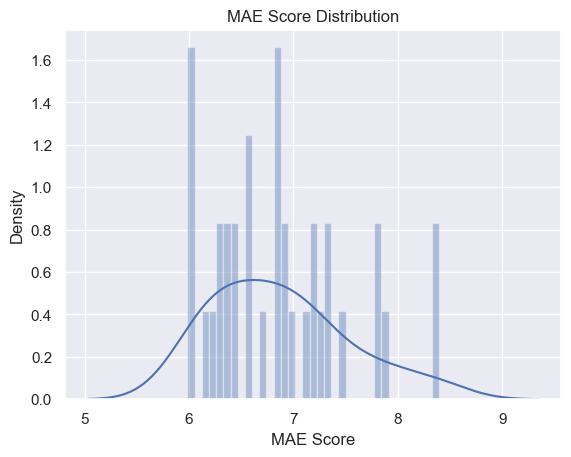

In [19]:
sns.set(style="darkgrid")
sns.distplot(mae_values, bins=35).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

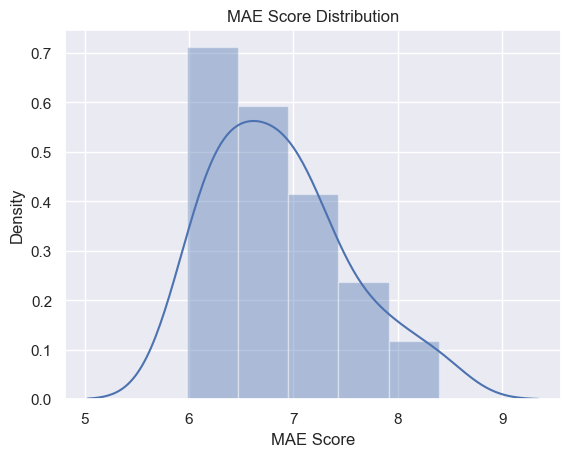

In [15]:
sns.set(style="darkgrid")
sns.distplot(mae_values).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

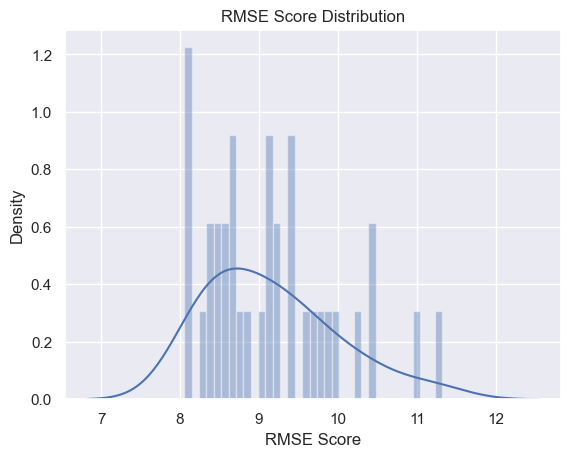

In [20]:
sns.set(style="darkgrid")
sns.distplot(rmse_values, bins=35).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

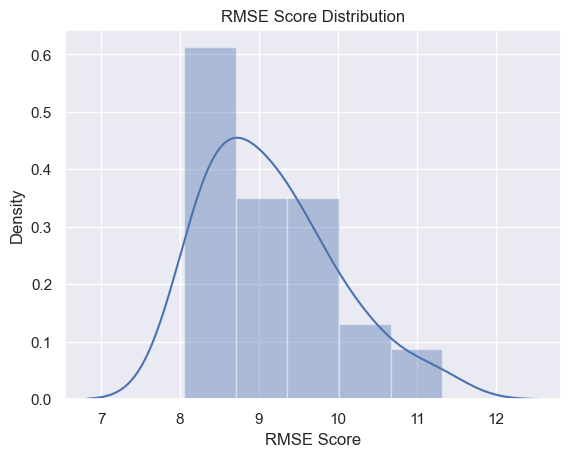

In [17]:
sns.set(style="darkgrid")
sns.distplot(rmse_values).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

# Results

In [18]:
compare_df.sort_values(by=['MAE'])

,Name,MAE,MAPE,MSE,RMSE
0,Vanilla LSTM 2,6.8678,0.0164,84.4311,9.1521


https://machinelearningmastery.com/estimate-number-experiment-repeats-stochastic-machine-learning-algorithms/